In [96]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask
from dask import delayed, multiprocessing, compute
from dask.diagnostics import ProgressBar
from astropy.time import Time
import seaborn.apionly as sns

from icecube import dataclasses

import comptools as comp

%matplotlib inline

In [29]:
df_data = comp.load_data(config='IC86.2012')

Starting out with 8020592 data events
data quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:    1.0    1.0
       passed_InIceQualityCuts:  0.918  0.918
                 num_hits_1_60:    1.0  0.918
             reco_energy_range:    1.0  0.918




/home/jbourbeau/cr-composition/comptools/dataframe_functions.py:135: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


In [ ]:
# def handle_mjd(f):
#     def inner(mjd_date):
#         date_time = dataclasses.I3Time(56043.448794).date_time
#         return f(date_time)
#     return

In [24]:
%timeit event_times = to_datetime(df_data.start_time_mjd[:100])

100 loops, best of 3: 8.44 ms per loop


In [25]:
%timeit event_times = to_datetime(df_data.start_time_mjd.values[:100])

100 loops, best of 3: 8.28 ms per loop


In [ ]:
event_times

In [27]:
df_data.start_time_mjd[:100]

0     56043.448794
1     56043.448801
2     56043.448848
3     56043.448872
4     56043.448873
5     56043.448916
6     56043.448917
7     56043.448925
8     56043.448963
9     56043.448992
10    56043.449129
11    56043.449151
12    56043.449155
13    56043.449203
14    56043.449246
15    56043.449309
16    56043.449320
17    56043.449324
18    56043.449352
19    56043.449418
20    56043.449422
21    56043.449439
22    56043.449467
23    56043.449472
24    56043.449578
25    56043.449642
26    56043.449754
27    56043.449772
28    56043.449780
29    56043.449819
          ...     
70    56043.451712
71    56043.451779
72    56043.451795
73    56043.451901
74    56043.451918
75    56043.452023
76    56043.452072
77    56043.452125
78    56043.452163
79    56043.452225
80    56043.452292
81    56043.452315
82    56043.452342
83    56043.452383
84    56043.452439
85    56043.452531
86    56043.452582
87    56043.452767
88    56043.452798
89    56043.452804
90    56043.452816
91    56043.

In [38]:
ts = [56043.448917, 56043.448925, 56043.448963]

In [31]:
astro_times = Time(ts, format='mjd')

In [78]:
%timeit pd.to_datetime(Time(df_data.start_time_mjd[:1000], format='mjd').datetime)

100 loops, best of 3: 7.17 ms per loop


In [72]:
%timeit Time(df_data.start_time_mjd.values[:1000], format='mjd').datetime

100 loops, best of 3: 6.83 ms per loop


In [67]:
astro_times = pd.to_datetime(Time(df_data.start_time_mjd, format='mjd').datetime)

In [68]:
astro_times

DatetimeIndex(['2012-04-26 10:46:15.770567', '2012-04-26 10:46:16.407866',
               '2012-04-26 10:46:20.431552', '2012-04-26 10:46:22.564666',
               '2012-04-26 10:46:22.613222', '2012-04-26 10:46:26.354454',
               '2012-04-26 10:46:26.467253', '2012-04-26 10:46:27.132420',
               '2012-04-26 10:46:30.414603', '2012-04-26 10:46:32.917071',
               ...
               '2013-05-02 09:40:28.156702', '2013-05-02 09:40:29.071259',
               '2013-05-02 09:40:31.898623', '2013-05-02 09:40:37.589210',
               '2013-05-02 09:40:51.821445', '2013-05-02 09:40:55.487617',
               '2013-05-02 09:41:11.400919', '2013-05-02 09:41:12.314264',
               '2013-05-02 09:41:17.911653', '2013-05-02 09:41:26.148951'],
              dtype='datetime64[ns]', length=7363638, freq=None)

In [82]:
day_count = pd.Series([1]*len(astro_times), index=astro_times).resample('D').sum()

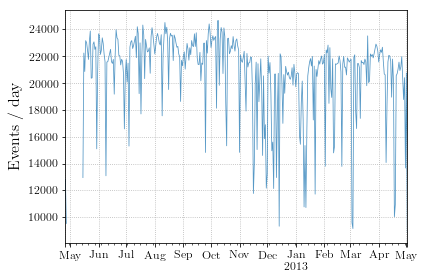

In [83]:
# with plt.rc_context({'text.usetex': False}):
fig, ax = plt.subplots()
day_count.plot(ls='-', marker='None', alpha=0.75, ax=ax)
ax.set_ylabel('Events / day')
ax.grid()
plt.show()

In [12]:
comp.datafunctions.get_data_configs()

['IC86.2011', 'IC86.2012', 'IC86.2013', 'IC86.2014', 'IC86.2015']

In [23]:
@np.vectorize
def mjd_to_datetime(mjd_date):
    date_time = dataclasses.I3Time(mjd_date).date_time
    return pd.to_datetime(date_time)

In [24]:
mjd_to_datetime([56043.452767, 56043.452798])

array([Timestamp('2012-04-26 10:51:59.068800'),
       Timestamp('2012-04-26 10:52:01.747200')], dtype=object)

In [25]:
@delayed
def get_event_rate_series(config):
    df_data = comp.load_data(config=config)
#     date_times = pd.to_datetime(Time(df_data.start_time_mjd, format='mjd').datetime)
    date_times = mjd_to_datetime(df_data.start_time_mjd)
    day_count = pd.Series([1]*len(date_times), index=date_times).resample('D').sum()
    return day_count

In [64]:
configs = comp.datafunctions.get_data_configs()
# configs = ['IC86.2012', 'IC86.2013']
n_jobs = len(configs)

config_day_counts = {config: get_event_rate_series(config) for config in configs}
with ProgressBar():
    config_day_counts = compute(config_day_counts, get=multiprocessing.get, num_workers=n_jobs)[0]

[                                        ] | 0% Completed |  1min  1.0sStarting out with 7719417 data events
[                                        ] | 0% Completed |  1min  1.3sdata quality cut event flow:
[                                        ] | 0% Completed |  1min  1.4s      passed_IceTopQualityCuts:    1.0    1.0
[                                        ] | 0% Completed |  1min  1.5sFractionContainment_Laputop_InIce:    1.0    1.0
[                                        ] | 0% Completed |  1min  1.6s       passed_InIceQualityCuts:  0.889  0.889
[                                        ] | 0% Completed |  1min  1.7s                 num_hits_1_60:    1.0  0.889
[                                        ] | 0% Completed |  1min  1.8s             reco_energy_range:    1.0  0.889


[                                        ] | 0% Completed |  1min  3.9sStarting out with 8020592 data events
[                                        ] | 0% Completed |  1min  4.4sdata quality cut even

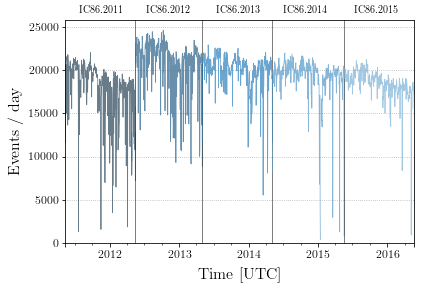

In [111]:
with sns.color_palette('Blues_d', len(configs)):
    fig, ax = plt.subplots()
    for config in configs:
        day_count = config_day_counts[config]
        day_count.plot(logy=False, ls='-', marker='None', alpha=0.75, label=config, ax=ax)
        ax.axvline(day_count.index.max(), marker='None', ls='-', color='k', lw=0.5)
        ax.text(day_count.index[len(day_count)//5], 2.65e4, config)
    ax.set_ylim(0)
    ax.set_ylabel('Events / day')
    ax.set_xlabel('Time [UTC]')
    ax.grid(axis='y')
#     ax.legend()
    plt.savefig(os.path.join(comp.paths.figures_dir, 'data-event-rate.png'))
    plt.show()

In [79]:
day_count.index[len(day_count)//2]

Timestamp('2015-11-06 00:00:00', freq='D')

In [34]:
%%timeit
date_times = mjd_to_datetime(df_data.start_time_mjd[:100])

100 loops, best of 3: 8.61 ms per loop


In [35]:
%%timeit
date_times = mjd_to_datetime(df_data.start_time_mjd[:100].values)

100 loops, best of 3: 8.62 ms per loop


In [36]:
%%timeit
date_times = pd.to_datetime(Time(df_data.start_time_mjd[:100], format='mjd').datetime)

1000 loops, best of 3: 1.07 ms per loop


TypeError: Incompatible Data Type

In [46]:
@delayed
def get_arange(l):
    return np.arange(l)

In [56]:
d = {l: get_arange(l) for l in range(1, 10)}

In [57]:
d = compute(d, get=multiprocessing.get, num_workers=len(d))[0]

In [60]:
d

{1: array([0]),
 2: array([0, 1]),
 3: array([0, 1, 2]),
 4: array([0, 1, 2, 3]),
 5: array([0, 1, 2, 3, 4]),
 6: array([0, 1, 2, 3, 4, 5]),
 7: array([0, 1, 2, 3, 4, 5, 6]),
 8: array([0, 1, 2, 3, 4, 5, 6, 7]),
 9: array([0, 1, 2, 3, 4, 5, 6, 7, 8])}